In [3]:
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.decomposition import NMF
from sklearn.model_selection import cross_val_score
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

In [4]:
df_post = pd.read_csv('data/processed/posts_w_labels.csv')
df_post

,author,created_utc,id,link_flair_text,num_comments,permalink,score,selftext,title,name,author_fullname,word_count,created_datetime,year,sentences_topics,sentences_labels,Label,sentences
0,Ok-Slide-9849,1701251429,186lthy,NaN,2,/r/QAnonCasualties/comments/186lthy/a_belated_...,4,\tI've known about this group for a while and ...,"A belated post, does the it ever end?",t3_186lthy,t2_o416vnkb,924,1701251429000,2023,"[68, -1, -1, 0, 270, -1, 70, -1, -1, -1, -1, -...",['Social Deterioration and Relationship Strain'],['Social Deterioration and Relationship Strain'],"[""\tI've known about this group for a while an..."
1,wanderingjeannie,1660010267,wjquol,NaN,3,/r/QAnonCasualties/comments/wjquol/q_anti_vax_...,13,\n\n\nDivorce is difficult situation generally...,Q anti Vax mom using the kids to hurt the Ex h...,t3_wjquol,t2_q75aaxj9,535,1660010267000,2022,"[-1, 42, 14, -1, -1, 188, 54, -1, -1, -1, -1, ...",['Social Deterioration and Relationship Strain...,['Social Deterioration and Relationship Strain...,"[""\n\n\nDivorce is difficult situation general..."
2,Mamailla,1611614013,l4zfzt,NaN,9,/r/QAnonCasualties/comments/l4zfzt/qanon_frien...,74,\n\n\nFive years ago when Trump began his camp...,Qanon friends sound like stories from Jonestown,t3_l4zfzt,t2_2yo216d6,236,1611614013000,2021,"[-1, 12, -1, -1, 2, -1, 44, 286]",['Social Deterioration and Relationship Strain'],['Social Deterioration and Relationship Strain'],['\n\n\nFive years ago when Trump began his ca...
3,getsomeyayas,1630144463,pd70my,NaN,5,/r/QAnonCasualties/comments/pd70my/i_think_im_...,17,"\n\n\nhi, just using my throwaway to rant a li...",i think i'm beginning to lose my uncle,t3_pd70my,t2_4gftpyni,521,1630144463000,2021,"[185, -1, -1, 350, 4, -1, -1, -1, -1, 212, -1,...","['Interpersonal Harm and Moral Disregard', 'As...","['Asian and Immigrant Family Dynamics', 'Inter...","['\n\n\nhi, just using my throwaway to rant a ..."
4,f_print,1597152737,i7rvmd,NaN,11,/r/QAnonCasualties/comments/i7rvmd/looking_for...,9,\n\n*Tl;dr What is the best source for Q-Anon....,Looking for best source of QAnon material to h...,t3_i7rvmd,t2_b7t0diw,383,1597152737000,2020,"[104, -1, 37, 37, -1, 139, -1, 397, 104, 73, -...",['Radical Ideological Alignment and Intoleranc...,"['COVID-19 Lockdowns', 'YouTube Algorithms', '...",['\n\n*Tl;dr\xa0What is the best source for Q-...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12742,SherlocktheWarlock,1703013286,18m9vcd,NaN,24,/r/QAnonCasualties/comments/18m9vcd/came_back_...,165,"“Well, they have to do that in order to red pi...","Came back for a shelf, left with more",t3_18m9vcd,t2_8vut8l97,615,1703013286000,2023,"[292, 159, -1, -1, 1, 49, 19, -1, 1, -1, 51, 0...",['Alternative Media Use and Information Exposu...,"['War-Inducing Rhetoric', 'Alternative Media U...","['“Well, they have to do that in order to red ..."
12743,Hot-Owl-2243,1732551047,1gzmfhy,NaN,30,/r/QAnonCasualties/comments/1gzmfhy/not_sure_i...,88,…but both my adult children are complete consp...,Not sure if it is QAnon…,t3_1gzmfhy,t2_5malttq2,179,1732551047000,2024,"[2, -1, -1, -1, -1, -1, -1, -1, -1, 252]",[],[],['…but both my adult children are complete con...
12744,Desperate-Thing1784,1693987388,16be8b5,NaN,2,/r/QAnonCasualties/comments/16be8b5/crazy_thin...,1,"■■■■■■■■■■SHE VOTES■■■■■■■■■■■\n\n●""HE didn't ...",CRAZY THINGS MY MOM SAYS HAVE A LAUGH AND ANEU...,t3_16be8b5,t2_c3pdtjjk,261,1693987388000,2023,[-1],[],[],"['■■■■■■■■■■SHE VOTES■■■■■■■■■■■\n\n●""HE didn\..."
12745,DeekALeek,1676416318,112j2pc,NaN,21,/r/QAnonCasualties/comments/112j2pc/i_helped_a...,102,"⚠️ TRIGGER WARNING: Domestic abuse, child abus...",I Helped a Friend Move Out of her Q-Fiancé’s H...,t3_112j2pc,t2_6emlogf8,824,1676416318000,2023,"[-1, -1, -1, -1, -1, -1, -1, -1, 20, -1, -1, -...","['Physical Health Disorders', 'Physical Health...",['Radical Ideological Alignment and Intoleranc...,"['⚠️ TRIGGER WARNING: Domestic abuse, child ab..."


In [5]:
import ast
df_post['Label'] = df_post['Label'].apply(ast.literal_eval)

In [6]:
df_post = df_post[df_post.Label.apply(len)>0]
len(df_post)

10860

Remove "Unknown"

In [11]:
# Unknown is only for sankey viz
def remove_unknown(x):
    if 'Unknown' in x:
        x.remove('Unknown')
    return x
df_post['Label'] = df_post['Label'].apply(lambda x: remove_unknown(x))

In [12]:
post2labels = df_post['Label'].to_dict()

In [8]:
post2labels

{0: ['Social Deterioration and Relationship Strain'],
 1: ['Social Deterioration and Relationship Strain',
  'Child Harm and Elite Abuse Narratives'],
 2: ['Social Deterioration and Relationship Strain'],
 3: ['Asian and Immigrant Family Dynamics',
  'Interpersonal Harm and Moral Disregard',
  'Unknown'],
 4: ['COVID-19 Lockdowns',
  'YouTube Algorithms',
  'Child Harm and Elite Abuse Narratives',
  'Radical Ideological Alignment and Intolerance'],
 6: ['Social Deterioration and Relationship Strain',
  'Public Health Mistrust and Resistance'],
 7: ['Defamatory Conspiracy Targeting Public Figures',
  'Epistemic Rigidity and Distrust in Expertise',
  'Alternative Media Use and Information Exposure',
  'Social Deterioration and Relationship Strain',
  'Conservative Political Identity',
  'Pro-Trump',
  'Unknown'],
 8: ["Trump's Election",
  'Interpersonal Harm and Moral Disregard',
  'Physical Health Disorders',
  'Pro-Trump'],
 9: ['Policy Defiance'],
 10: ['Child Harm and Elite Abuse Na

Remove duplicate

In [13]:
seen = set()
post2labels_dd = {}

for key, value in post2labels.items():
    value_tuple = tuple(value)  # Convert list to tuple to make it hashable
    if value_tuple not in seen:
        post2labels_dd[key] = value
        seen.add(value_tuple)

In [9]:
def create_topic_matrix_nmf(post2labels, use_counts=True, topic_list=None):
    """
    Create topic matrix for NMF
    If use_counts=True, uses topic frequency per post
    If use_counts=False, uses binary presence/absence
    """
    if topic_list is None:
        all_topics = set()
        for topics in post2labels.values():
            all_topics.update(topics)
        topic_list = sorted(list(all_topics))
    
    post_ids = list(post2labels.keys())
    n_posts = len(post_ids)
    n_topics = len(topic_list)
    
    topic_matrix = np.zeros((n_posts, n_topics), dtype=float)
    topic_to_idx = {topic: i for i, topic in enumerate(topic_list)}
    
    for i, post_id in enumerate(post_ids):
        post_topics = post2labels[post_id]
        
        if use_counts:
            # Count frequency of each topic (for repeated topics)
            topic_counts = {}
            for topic in post_topics:
                topic_counts[topic] = topic_counts.get(topic, 0) + 1
            
            for topic, count in topic_counts.items():
                if topic in topic_to_idx:
                    topic_matrix[i, topic_to_idx[topic]] = count
        else:
            # Binary presence/absence
            for topic in set(post_topics):
                if topic in topic_to_idx:
                    topic_matrix[i, topic_to_idx[topic]] = 1
    
    return topic_matrix, topic_list, post_ids

def find_optimal_nmf_components(topic_matrix, n_components_range=range(2, 16), 
                               random_state=42, max_iter=500):
    """Find optimal number of components using reconstruction error and silhouette score"""
    results = {}
    
    print("Finding optimal number of components...")
    
    for n_components in n_components_range:
        print(f"Testing {n_components} components...")
        
        # Fit NMF
        nmf = NMF(
            n_components=n_components,
            init='nndsvda',  # Better initialization
            random_state=random_state,
            max_iter=max_iter,
            alpha_W=0.01,  # Small regularization
            alpha_H=0.01,
            l1_ratio=0.5
        )
        
        W = nmf.fit_transform(topic_matrix)
        H = nmf.components_
        
        # Calculate reconstruction error
        reconstruction_error = nmf.reconstruction_err_
        
        # Calculate explained variance ratio
        total_variance = np.var(topic_matrix)
        residual_variance = np.var(topic_matrix - W @ H)
        explained_variance_ratio = 1 - (residual_variance / total_variance)
        
        # Calculate silhouette score (approximate cluster quality)
        # Use component assignments (argmax of W)
        component_assignments = np.argmax(W, axis=1)
        
        # Only calculate if we have enough variety in assignments
        if len(np.unique(component_assignments)) > 1:
            silhouette = silhouette_score(topic_matrix, component_assignments)
        else:
            silhouette = -1  # Invalid score
        
        results[n_components] = {
            'model': nmf,
            'W': W,
            'H': H,
            'reconstruction_error': reconstruction_error,
            'explained_variance_ratio': explained_variance_ratio,
            'silhouette_score': silhouette,
            'component_assignments': component_assignments
        }
    
    return results

def plot_nmf_metrics(results):
    """Plot metrics to help select optimal number of components"""
    n_components = list(results.keys())
    reconstruction_errors = [results[k]['reconstruction_error'] for k in n_components]
    explained_variance_ratios = [results[k]['explained_variance_ratio'] for k in n_components]
    silhouette_scores = [results[k]['silhouette_score'] for k in n_components]
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Reconstruction error
    axes[0].plot(n_components, reconstruction_errors, 'o-', linewidth=2, markersize=8)
    axes[0].set_xlabel('Number of Components')
    axes[0].set_ylabel('Reconstruction Error')
    axes[0].set_title('Reconstruction Error vs Components')
    axes[0].grid(True, alpha=0.3)
    
    # Explained variance ratio
    axes[1].plot(n_components, explained_variance_ratios, 's-', linewidth=2, markersize=8, color='green')
    axes[1].set_xlabel('Number of Components')
    axes[1].set_ylabel('Explained Variance Ratio')
    axes[1].set_title('Explained Variance vs Components')
    axes[1].grid(True, alpha=0.3)
    
    # Silhouette score
    valid_silhouette = [(k, v) for k, v in zip(n_components, silhouette_scores) if v > -1]
    if valid_silhouette:
        valid_k, valid_scores = zip(*valid_silhouette)
        axes[2].plot(valid_k, valid_scores, '^-', linewidth=2, markersize=8, color='red')
    axes[2].set_xlabel('Number of Components')
    axes[2].set_ylabel('Silhouette Score')
    axes[2].set_title('Silhouette Score vs Components')
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print recommendations
    print("\nModel Selection Recommendations:")
    print("-" * 40)
    
    # Find elbow in reconstruction error
    errors = np.array(reconstruction_errors)
    error_diffs = np.diff(errors)
    error_diffs2 = np.diff(error_diffs)
    if len(error_diffs2) > 0:
        elbow_idx = np.argmax(error_diffs2) + 2  # +2 due to double diff
        elbow_k = n_components[elbow_idx] if elbow_idx < len(n_components) else n_components[-1]
        print(f"Elbow method suggests: {elbow_k} components")
    
    # Best explained variance (plateau)
    if len(explained_variance_ratios) > 2:
        var_improvements = np.diff(explained_variance_ratios)
        small_improvements = np.where(var_improvements < 0.01)[0]
        if len(small_improvements) > 0:
            plateau_k = n_components[small_improvements[0] + 1]
            print(f"Explained variance plateau at: {plateau_k} components")
    
    # Best silhouette
    if valid_silhouette:
        best_sil_k = valid_k[np.argmax(valid_scores)]
        print(f"Best silhouette score: {best_sil_k} components")

def analyze_nmf_components(results, n_components, topic_list, top_n_topics=10):
    """Analyze NMF components (personas) and their topic profiles"""
    result = results[n_components]
    H = result['H']  # Components × Topics
    W = result['W']  # Posts × Components
    
    print(f"\nNMF Component Analysis ({n_components} components):")
    print("=" * 80)
    
    component_profiles = {}
    
    for comp_id in range(n_components):
        # Get topic weights for this component
        topic_weights = H[comp_id, :]
        
        # Get top topics
        top_topic_indices = np.argsort(topic_weights)[-top_n_topics:][::-1]
        
        # Calculate component statistics
        component_strengths = W[:, comp_id]
        component_size = np.sum(component_strengths > 0.1)  # Posts with significant loading
        component_dominance = np.sum(np.argmax(W, axis=1) == comp_id)  # Posts where this is dominant
        
        print(f"\nComponent {comp_id + 1}:")
        print(f"  Posts with significant loading (>0.1): {component_size}")
        print(f"  Posts where dominant: {component_dominance}")
        print(f"  Top topics:")
        
        component_profiles[comp_id] = {
            'significant_posts': component_size,
            'dominant_posts': component_dominance,
            'top_topics': [],
            'topic_weights': topic_weights
        }
        
        for i, topic_idx in enumerate(top_topic_indices):
            topic_name = topic_list[topic_idx]
            weight = topic_weights[topic_idx]
            print(f"    {i+1:2d}. {topic_name[:60]:<60} ({weight:.3f})")
            
            component_profiles[comp_id]['top_topics'].append({
                'topic': topic_name,
                'weight': weight,
                'rank': i+1
            })
    
    return component_profiles

def plot_nmf_heatmap(results, n_components, topic_list, figsize=(15, 10)):
    """Create heatmap showing topic weights by component"""
    result = results[n_components]
    H = result['H']
    
    # Create DataFrame for heatmap
    df_heatmap = pd.DataFrame(
        H.T,
        index=[t[:40] + '...' if len(t) > 40 else t for t in topic_list],
        columns=[f'Component {i+1}' for i in range(n_components)]
    )
    
    plt.figure(figsize=figsize)
    sns.heatmap(df_heatmap, 
                cmap='YlOrRd',
                annot=False,
                cbar_kws={'label': 'Topic Weight'})
    plt.title(f'NMF Topic Weights by Component ({n_components} components)')
    plt.xlabel('Components (Personas)')
    plt.ylabel('Topics')
    plt.tight_layout()
    plt.show()

def get_representative_posts_nmf(post2labels, df_post, results, n_components, post_ids, 
                                n_posts_per_component=5, min_loading=0.1):
    """Get representative posts for each NMF component"""
    result = results[n_components]
    W = result['W']
    
    representative_posts = {}
    
    for comp_id in range(n_components):
        # Get posts with high loading on this component
        component_loadings = W[:, comp_id]
        
        # Filter posts with significant loading
        significant_posts = component_loadings > min_loading
        significant_indices = np.where(significant_posts)[0]
        
        if len(significant_indices) == 0:
            continue
        
        # Sort by loading strength
        significant_loadings = component_loadings[significant_indices]
        sorted_indices = np.argsort(significant_loadings)[-n_posts_per_component:][::-1]
        top_post_indices = significant_indices[sorted_indices]
        
        representative_posts[comp_id] = []
        
        for post_idx in top_post_indices:
            post_id = post_ids[post_idx]
            loading = component_loadings[post_idx]
            
            try:
                text = df_post._get_value(post_id, 'selftext')
                representative_posts[comp_id].append({
                    'post_id': post_id,
                    'component_loading': loading,
                    'text': text[:300] + '...' if len(text) > 300 else text,
                    'topics': post2labels[post_id]
                })
            except:
                continue
    
    return representative_posts

def analyze_component_overlap(results, n_components, threshold=0.1):
    """Analyze how much posts overlap between components"""
    result = results[n_components]
    W = result['W']
    
    # Find posts that have significant loading on multiple components
    significant_loadings = W > threshold
    posts_per_component = np.sum(significant_loadings, axis=0)
    components_per_post = np.sum(significant_loadings, axis=1)
    
    print(f"\nComponent Overlap Analysis (threshold={threshold}):")
    print("=" * 50)
    print(f"Posts with multiple component membership: {np.sum(components_per_post > 1)}")
    print(f"Posts with single component membership: {np.sum(components_per_post == 1)}")
    print(f"Posts with no significant membership: {np.sum(components_per_post == 0)}")
    
    print(f"\nPosts per component:")
    for i, count in enumerate(posts_per_component):
        print(f"  Component {i+1}: {count} posts")
    
    # Component similarity matrix
    component_similarity = np.corrcoef(W.T)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(component_similarity, 
                annot=True, 
                cmap='RdBu_r', 
                center=0,
                xticklabels=[f'Comp {i+1}' for i in range(n_components)],
                yticklabels=[f'Comp {i+1}' for i in range(n_components)])
    plt.title('Component Similarity Matrix')
    plt.tight_layout()
    plt.show()

def create_nmf_persona_summary(component_profiles, representative_posts):
    """Create persona interpretation summary"""
    print("\n" + "=" * 80)
    print("NMF PERSONA INTERPRETATION")
    print("=" * 80)
    
    for comp_id, profile in component_profiles.items():
        print(f"\nComponent {comp_id + 1} - Potential Persona:")
        print(f"Significant posts: {profile['significant_posts']}")
        print(f"Dominant posts: {profile['dominant_posts']}")
        print(f"Key characteristics:")
        
        # Top 5 topics
        for i, topic_info in enumerate(profile['top_topics'][:5]):
            print(f"  {i+1}. {topic_info['topic']} (weight={topic_info['weight']:.3f})")
        
        # Persona interpretation
        top_topics = [t['topic'] for t in profile['top_topics'][:3]]
        print(f"\nSuggested persona: Based on {', '.join(top_topics)}")
        
        # Show one representative post
        if comp_id in representative_posts and representative_posts[comp_id]:
            best_post = representative_posts[comp_id][0]
            print(f"Representative post (loading={best_post['component_loading']:.3f}):")
            print(f"  Topics: {best_post['topics']}")
            print(f"  Text: {best_post['text'][:200]}...")
        
        print("-" * 60)

def run_nmf_analysis(post2labels, df_post, n_components_range=range(2, 16), use_counts=True):
    """Run complete NMF analysis"""
    print("Creating topic matrix...")
    topic_matrix, topic_list, post_ids = create_topic_matrix_nmf(
        post2labels, use_counts=use_counts
    )
    
    print(f"Matrix shape: {topic_matrix.shape}")
    print(f"Topics: {len(topic_list)}")
    print(f"Posts: {len(post_ids)}")
    print(f"Sparsity: {(topic_matrix == 0).sum() / topic_matrix.size:.3f}")
    print(f"Using counts: {use_counts}")
    
    print("\nFinding optimal number of components...")
    results = find_optimal_nmf_components(topic_matrix, n_components_range)
    
    print("\nPlotting metrics...")
    plot_nmf_metrics(results)
    
    # Choose optimal number (you can adjust this)
    optimal_n_components = 6  # Adjust based on the metrics plots
    
    print(f"\nAnalyzing {optimal_n_components} component solution...")
    component_profiles = analyze_nmf_components(results, optimal_n_components, topic_list)
    
    print("\nCreating component heatmap...")
    plot_nmf_heatmap(results, optimal_n_components, topic_list)
    
    print("\nAnalyzing component overlap...")
    analyze_component_overlap(results, optimal_n_components)
    
    print("\nGetting representative posts...")
    representative_posts = get_representative_posts_nmf(
        post2labels, df_post, results, optimal_n_components, post_ids
    )
    
    create_nmf_persona_summary(component_profiles, representative_posts)
    
    return {
        'results': results,
        'topic_matrix': topic_matrix,
        'topic_list': topic_list,
        'post_ids': post_ids,
        'component_profiles': component_profiles,
        'representative_posts': representative_posts,
        'optimal_n_components': optimal_n_components
    }

k=2: coherence=0.3727
k=3: coherence=0.3763
k=4: coherence=0.3714
k=5: coherence=0.3471
k=6: coherence=0.3319
k=7: coherence=0.3205
k=8: coherence=0.3078
k=9: coherence=0.3103
k=10: coherence=0.2782
k=11: coherence=0.2661
k=12: coherence=0.2755
k=13: coherence=0.2534
k=14: coherence=0.2628
k=15: coherence=0.2502


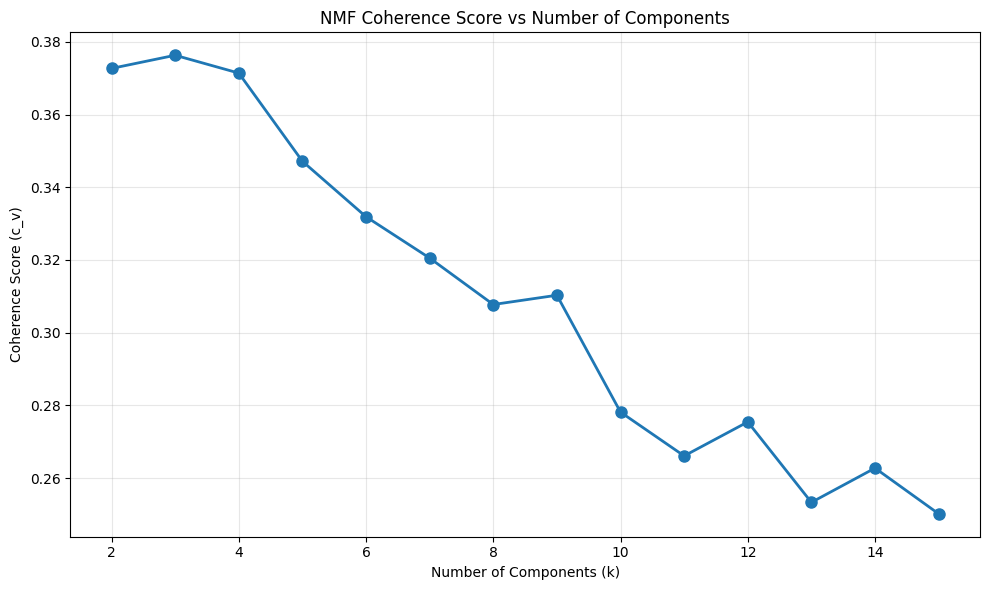


Best coherence at k=3: 0.3763


In [20]:
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel

def calculate_nmf_coherence(results, topic_list, post2labels, post_ids, n_components_range):
    """Calculate coherence scores for NMF models"""
    # Prepare texts for coherence calculation
    texts = [[topic for topic in post2labels[post_id]] for post_id in post_ids]
    dictionary = Dictionary(texts)
    
    coherence_scores = {}
    
    for n_components in n_components_range:
        result = results[n_components]
        H = result['H']  # Components × Topics
        
        # Extract top topics for each component
        top_n = 10
        topics = []
        for comp_id in range(n_components):
            topic_weights = H[comp_id, :]
            top_indices = np.argsort(topic_weights)[-top_n:][::-1]
            top_topics = [topic_list[idx] for idx in top_indices]
            topics.append(top_topics)
        
        # Calculate coherence
        cm = CoherenceModel(
            topics=topics,
            texts=texts,
            dictionary=dictionary,
            coherence='c_v'
        )
        coherence_scores[n_components] = cm.get_coherence()
        print(f"k={n_components}: coherence={coherence_scores[n_components]:.4f}")
    
    return coherence_scores

def plot_nmf_coherence(coherence_scores):
    """Plot coherence scores"""
    k_values = list(coherence_scores.keys())
    scores = list(coherence_scores.values())
    
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, scores, 'o-', linewidth=2, markersize=8)
    plt.xlabel('Number of Components (k)')
    plt.ylabel('Coherence Score (c_v)')
    plt.title('NMF Coherence Score vs Number of Components')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    best_k = k_values[np.argmax(scores)]
    print(f"\nBest coherence at k={best_k}: {coherence_scores[best_k]:.4f}")

# Usage
n_components_range = list(nmf_results['results'].keys())
coherence_scores = calculate_nmf_coherence(
    nmf_results['results'],
    nmf_results['topic_list'],
    post2labels_dd,
    nmf_results['post_ids'],
    n_components_range
)
plot_nmf_coherence(coherence_scores)

In [32]:
import itertools
nmf_cvs = dict(itertools.islice(coherence_scores.items(), 2, 15))
nmf_cvs

{4: 0.37139126581207477,
 5: 0.3471491285305596,
 6: 0.33189114694307476,
 7: 0.3205327371027501,
 8: 0.30775344593461473,
 9: 0.31030662508760787,
 10: 0.27816839447018127,
 11: 0.2661255995132969,
 12: 0.27547307533960835,
 13: 0.2533562985724766,
 14: 0.26277642679921553,
 15: 0.2502099059401152}

Get the LDA CVs from the other file:

In [25]:
lda_cvs = {4: 0.28243339037668713,
 5: 0.33503973096539486,
 6: 0.39886428417719794,
 7: 0.36300992867526355,
 8: 0.38522712840838896,
 9: 0.35205351022696146,
 10: 0.2829351119580476,
 11: 0.3675881593026658,
 12: 0.3492272315904543,
 13: 0.3201603099460358,
 14: 0.34493999540274894,
 15: 0.29529885768033737}

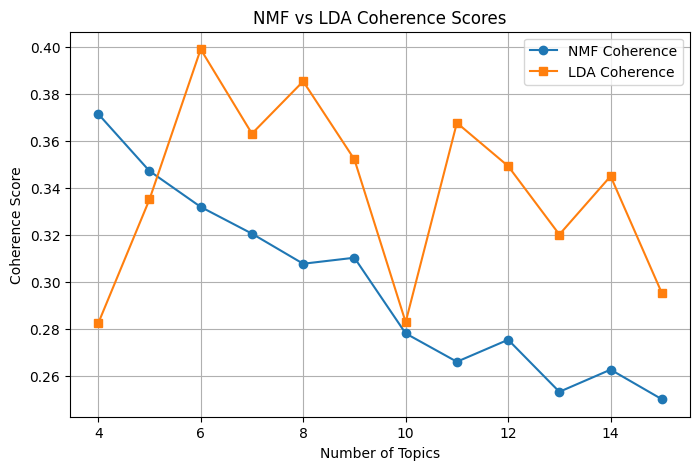

In [33]:
# Data
nmf_cvs = {
    4: 0.37139126581207477, 5: 0.3471491285305596, 6: 0.33189114694307476,
    7: 0.3205327371027501, 8: 0.30775344593461473, 9: 0.31030662508760787,
    10: 0.27816839447018127, 11: 0.2661255995132969, 12: 0.27547307533960835,
    13: 0.2533562985724766, 14: 0.26277642679921553, 15: 0.2502099059401152
}

lda_cvs = {
    4: 0.28243339037668713, 5: 0.33503973096539486, 6: 0.39886428417719794,
    7: 0.36300992867526355, 8: 0.38522712840838896, 9: 0.35205351022696146,
    10: 0.2829351119580476, 11: 0.3675881593026658, 12: 0.3492272315904543,
    13: 0.3201603099460358, 14: 0.34493999540274894, 15: 0.29529885768033737
}

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(list(nmf_cvs.keys()), list(nmf_cvs.values()), marker="o", label="NMF Coherence")
plt.plot(list(lda_cvs.keys()), list(lda_cvs.values()), marker="s", label="LDA Coherence")

plt.title("NMF vs LDA Coherence Scores")
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.legend()
plt.grid(True)
plt.show()


Creating topic matrix...
Matrix shape: (4243, 48)
Topics: 48
Posts: 4243
Sparsity: 0.910
Using counts: True

Finding optimal number of components...
Finding optimal number of components...
Testing 2 components...
Testing 3 components...
Testing 4 components...
Testing 5 components...
Testing 6 components...
Testing 7 components...
Testing 8 components...
Testing 9 components...
Testing 10 components...
Testing 11 components...
Testing 12 components...
Testing 13 components...
Testing 14 components...
Testing 15 components...

Plotting metrics...


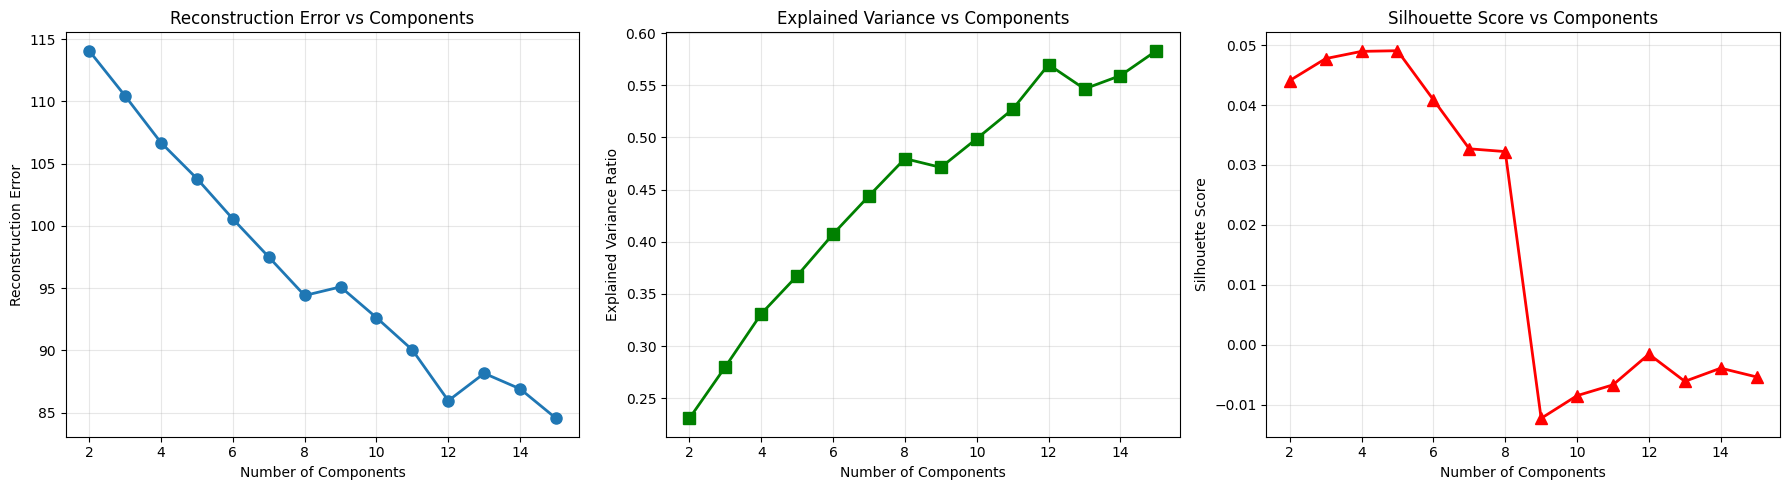


Model Selection Recommendations:
----------------------------------------
Elbow method suggests: 13 components
Explained variance plateau at: 9 components
Best silhouette score: 5 components

Analyzing 6 component solution...

NMF Component Analysis (6 components):

Component 1:
  Posts with significant loading (>0.1): 1816
  Posts where dominant: 987
  Top topics:
     1. Social Deterioration and Relationship Strain                 (2.323)
     2. Epistemic Rigidity and Distrust in Expertise                 (0.373)
     3. Religious Influence                                          (0.291)
     4. Psychological and Emotional Shifts                           (0.277)
     5. Lifestyle Changes Driven by Conspiratorial Beliefs           (0.247)
     6. Conservative Political Identity                              (0.244)
     7. Alternative Media Use and Information Exposure               (0.187)
     8. Facebook                                                     (0.149)
     9. Apocaly

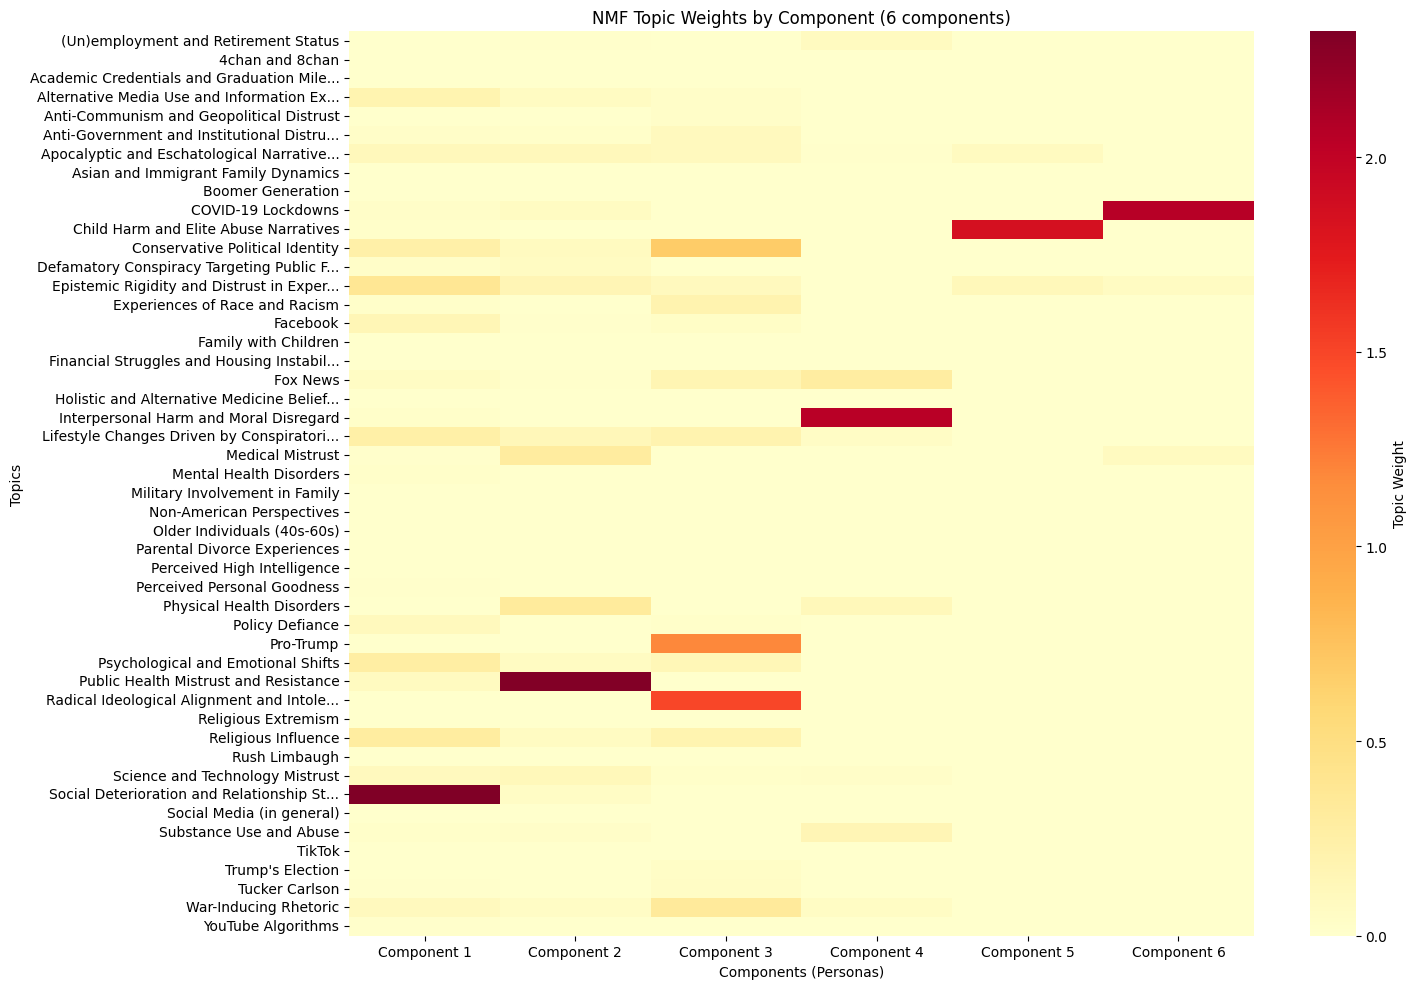


Analyzing component overlap...

Component Overlap Analysis (threshold=0.1):
Posts with multiple component membership: 2583
Posts with single component membership: 1213
Posts with no significant membership: 447

Posts per component:
  Component 1: 1816 posts
  Component 2: 1657 posts
  Component 3: 1816 posts
  Component 4: 1084 posts
  Component 5: 776 posts
  Component 6: 1016 posts


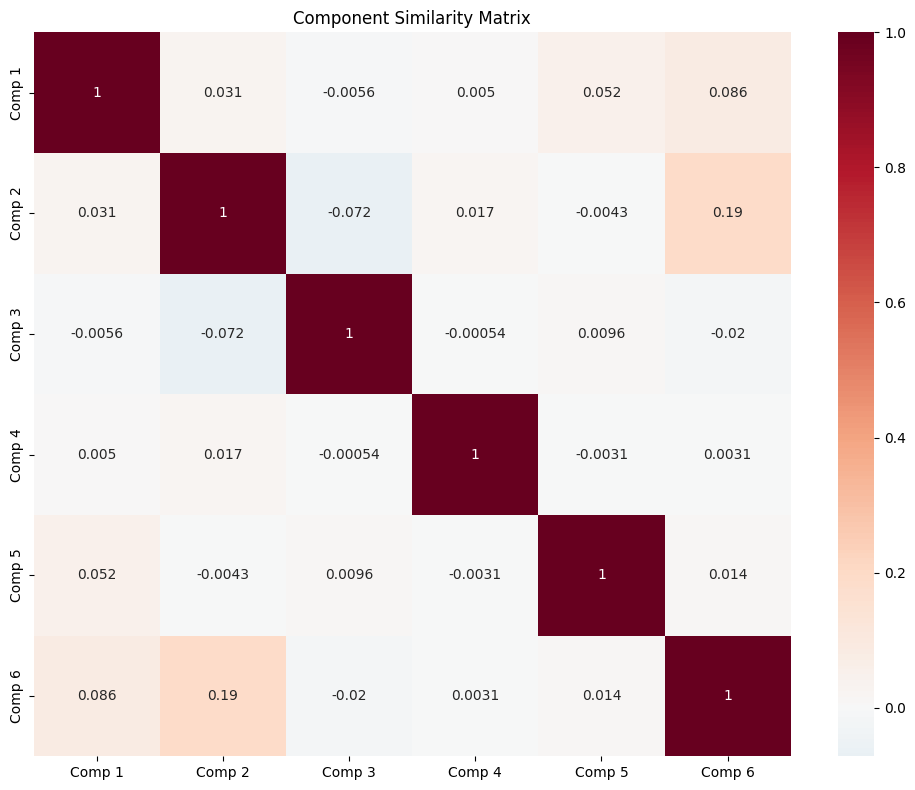


Getting representative posts...

NMF PERSONA INTERPRETATION

Component 1 - Potential Persona:
Significant posts: 1816
Dominant posts: 987
Key characteristics:
  1. Social Deterioration and Relationship Strain (weight=2.323)
  2. Epistemic Rigidity and Distrust in Expertise (weight=0.373)
  3. Religious Influence (weight=0.291)
  4. Psychological and Emotional Shifts (weight=0.277)
  5. Lifestyle Changes Driven by Conspiratorial Beliefs (weight=0.247)

Suggested persona: Based on Social Deterioration and Relationship Strain, Epistemic Rigidity and Distrust in Expertise, Religious Influence
Representative post (loading=0.585):
  Topics: ['Epistemic Rigidity and Distrust in Expertise', 'Apocalyptic and Eschatological Narratives', 'Alternative Media Use and Information Exposure', 'Child Harm and Elite Abuse Narratives', 'Social Deterioration and Relationship Strain', 'Religious Influence', 'Facebook', 'Conservative Political Identity', 'Interpersonal Harm and Moral Disregard', 'Psychologi

In [14]:
nmf_results = run_nmf_analysis(post2labels_dd, df_post, use_counts=True)
# 
# # Compare with binary version
# nmf_results_binary = run_nmf_analysis(post2labels, df_post, use_counts=False)